# Introduction

Continual learning for semantic segmentation is a field that has emerged recently and is quickly evolving. As a newcomer to the field, I wanted to quickly get in touched with the popular approaches and see by myself some concrete results. However, if one wants to rerun the experiments made in recent papers, which often use medium- to large-scale datasets such as Pascal-VOC, ADE20K or COCO, it would require several hours of training. 

Therefore, I took inspiration from the [Simple Deep Learning project](https://https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) by Luke Tonin in which he built MNIST-Extended, a semantic segmentation dataset  made from MNIST. While this is obviously a toy dataset, it has the benefit of giving quick feedback when tinkering with models.

This will also enable to explore common challenges of continual semantic segmentation such as Catastrophic forgetting, background shift, and the various combinations of setups where past/future classes are/are not in images and labeled as background. 

# TODO
1. [X]. Clean Evaluater
2. [X]Test Evaluater
3. Design metrics - How to measure catastrophic forgetting?
4. Experiments illustrating catastrophic forgetting
5. Explain background shift
6. Experiments illustrating background shift

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Using MNIST data for CL: Split MNIST benchmark**

In [1]:
# some initial imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import os
import sys

os.chdir("/content/gdrive/MyDrive/Colab Notebooks/mnist_continual_seg")
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/simple_deep_learning")

In [2]:
import simple_deep_learning
from simple_deep_learning.mnist_extended import semantic_segmentation

In [3]:
train_x, train_y, test_x, test_y = semantic_segmentation.create_semantic_segmentation_dataset(num_train_samples=1000,num_test_samples=2000)
train_y = np.concatenate([np.zeros_like(train_y[:,:,:,0:1]), train_y], axis=-1)
train_y[:,:,:, 0] = np.sum(train_y, axis=-1) == 0

test_y = np.concatenate([np.zeros_like(test_y[:,:,:,0:1]), test_y], axis=-1)
test_y[:,:,:, 0] = np.sum(test_y, axis=-1) == 0

train_y = np.argmax(train_y, axis=-1)
test_y = np.argmax(test_y, axis=-1)

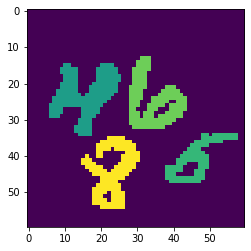

In [4]:
plt.imshow(test_y[10])

Now that the segmentation dataset is loaded, we need to adapt it to reflect the continual setup where classes are seen sequentially. To do so, we will implement a processing function that only keeps the groundtruth masks for the current learning step. For instance, if we divide the 10 classes from MNIST in 5 learning steps of 2 classes, then at step #0 the model is only trained to segment digits 0 and 1, while other digits on the image are labeled as background (i.e. label '0'). Then, at step #1 where the model must learn to segment 2's and 3's, digits 0-1 and 4-9 will be labeled as background, and so on.

This scenario reflects the common experimental setup in which segmentation masks are only available for current classes while objects that belong to past and future classes can still appear in scene images (e.g. from Pascal-VOC) but are labeled as background. This is a challenge specific to Continual Semantic Segmentation known as Background shift, which is addressed in several recent works (MiB, PLOP, SSUL, RECALL, etc). 

In [5]:
import torch.utils.data as data
class continual_mnist_extended(data.Dataset):
  def __init__(self, X, y, tasks: dict):
    self.X = X
    self.y = y
    self.classes = np.arange(self.y.shape[-1])
    self.tasks = tasks
    self.curr_task_id = 0
    self.curr_classes = [t+1 for t in self.tasks[self.curr_task_id]] + [0]
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def __getitem__(self, index):
    return self.curr_X[index], self.curr_y[index]

  def __len__(self):
    return len(self.curr_X)

  def get_curr_Xy(self):
    """
    Process masks for the current task and return
     images, segmentation masks.
    """
    processed_y = self.process_groundtruth(self.y)
    idx = np.where(np.sum(processed_y, axis=(1,2))!=0)[0]
    processed_X = self.X[idx]
    processed_y = processed_y[idx]
    processed_X = np.transpose(processed_X, (0,3,1,2))

    return processed_X, processed_y

  def process_groundtruth(self, segmentation_masks):
    """
    Remove groundtruth mask annotations of classes
     that are not from the current set of classes.
    """
    processed_masks = np.copy(segmentation_masks)
    processed_masks[np.isin(processed_masks,
                            self.curr_classes, invert=True)] = 0 
    return processed_masks

  def next_task(self):
    """
    Switch to next task. If the task was the last one, 
     go back to first task.
    """
    self.curr_task_id += 1
    if self.curr_task_id >= len(self.tasks):
      self.curr_task_id = 0

    self.set_curr_classes()
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def set_curr_classes(self):
    """Adjust current classes to current task and return them. """
    self.curr_classes = [t+1 for t in self.tasks[self.curr_task_id]] + [0]
    return self.curr_classes


#_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
#train_data = continual_mnist_extended(train_x, train_y, _tasks)

In [6]:
from torch import nn
class simple_seg_model(torch.nn.Module):
  def __init__(self, conv_filters=32, n_classes_per_task=[2]):
    super(simple_seg_model, self).__init__()
    self.conv_filters = conv_filters
    self.n_classes_per_task = n_classes_per_task

    self.block1 = nn.Sequential(
                     nn.Conv2d(1, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d((2,2))
                  )
    self.block2 = nn.Sequential(
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d((2,2))
                  )
    self.block3 = nn.Sequential(
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU()
                  )
    
    self.encoder = nn.Sequential(self.block1,
                                 self.block2,
                                 self.block3)

    self.block4 = nn.Sequential(
                     nn.Upsample(scale_factor=(2,2)),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU()
                  )
    
    self.block5 = nn.Sequential(
                     nn.Upsample(scale_factor=(2,2)),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU(),
                     nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1),
                     nn.ReLU()
                  )

    self.decoder = nn.Sequential(self.block4,
                                 self.block5)
    
    self.cls = nn.ModuleList(
            [nn.Conv2d(self.conv_filters, c, 1) for c in n_classes_per_task]
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    out = []
    for mod in self.cls:
        out.append(mod(x))
    x_o = torch.cat(out, dim=1)
    #x_o = torch.softmax(x_o)

    return x_o

model = simple_seg_model()

In [7]:
class Trainer:
  def __init__(self, model, n_classes, optim, curr_task=0):
    self.model = model
    self.criterion = nn.CrossEntropyLoss()
    self.n_classes = n_classes
    self.optim = optim
    self.curr_task = curr_task

  def train(self, cur_epoch, train_loader):
    """Train for 1 epoch."""
    epoch_loss = 0
    for cur_step, (images, labels) in enumerate(train_loader):
      images, labels = images.cuda().float(), labels.cuda().long()
      epoch_loss += self._train_step(images, labels)
    return epoch_loss / len(train_loader)

  def _train_step(self, images, labels):
    """Perform 1 training iteration."""
    self.optim.zero_grad()
    outputs = self.model(images)
    loss = self._compute_loss(outputs, labels)

    loss.backward()
    self.optim.step()
    return loss

  def next_task(self, new_classes):
    """Switch to next task."""
    self.n_classes = new_classes
    new_model = self._load_new_model(self.n_classes)
    self.model = new_model.cuda()
    self.curr_task += 1

  def _load_new_model(self, n_classes):
    """
    Helper function to create new model and
     load weights of past training.
    """
    new_model = self._make_model(n_classes)
    path_weights = self._get_path_weights()
    step_checkpoint = torch.load(path_weights, map_location="cpu")
    new_model.load_state_dict(step_checkpoint, strict=False)
    return new_model

  def _make_model(self, n_classes):
    """Helper function to create new model."""
    m_constructor = type(self.model)
    new_model = m_constructor(n_classes_per_task=n_classes)
    return new_model

  def _get_path_weights(self):
    """Helper function to get path to previous model's weights."""
    path = f"checkpoints/task-{self.curr_task}.pth"
    return path

  def _compute_loss(self, outputs, labels):
    return self.criterion(outputs, labels)





In [8]:
from importlib import reload
import metrics
reload(metrics)
reload(metrics.metrics_manager)
reload(metrics.metrics)
from metrics.metrics_manager import MetricsManager

class Evaluater:
  def __init__(self, model, metrics_manager):
    self.model = model
    self.metrics_manager = metrics_manager
    
  def test(self, test_loader):
    self.model.eval()
    self.metrics_manager.init_values()
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.cuda().float(), labels.float()
        predictions = self.model(images)
        _, class_predictions = torch.max(predictions, dim=1)
        class_predictions = class_predictions.cpu().long()
        self.metrics_manager.update(class_predictions, labels)
    self.metrics_manager.print_metrics()

In [9]:
# Initialize dataloader, optimizer and trainer
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_test_tasks = {0: [0,1], 1: [0,1,2,3], 2: [0,1,2,3,4,5], 3: [0,1,2,3,4,5,6,7], 4: [0,1,2,3,4,5,6,7,8,9]}
model = simple_seg_model(n_classes_per_task=[3])
train_data = continual_mnist_extended(train_x, train_y, _tasks)
train_loader = data.DataLoader(train_data, batch_size=36, shuffle=True)
test_data = continual_mnist_extended(test_x, test_y, _test_tasks)
test_loader = data.DataLoader(test_data, batch_size=1)
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())
trainer = Trainer(model,
                  n_classes=[len(train_data.curr_classes)],
                  optim=optimizer)
metrics_manager = MetricsManager(["confusion_matrix"], n_classes=3)
evaluater = Evaluater(model, metrics_manager)


{'n_classes': 3}


In [10]:
epoch_losses = []
for i in range(100):
  e_loss = trainer.train(i, train_loader)
  epoch_losses.append(e_loss)
  
  #if i > 25 :
  #trainer.test(test_loader)
evaluater.test(test_loader)
torch.save(model.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[[3.544029e+06 3.336200e+04 6.645000e+03]
 [7.784000e+03 1.117960e+05 6.600000e+01]
 [1.083300e+04 4.410000e+02 4.704400e+04]]


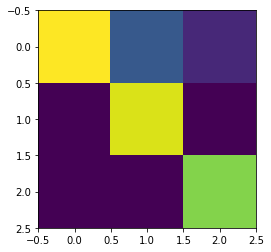

In [11]:
plt.imshow(metrics_manager.metrics[0].confusion_matrix/np.sum(metrics_manager.metrics[0].confusion_matrix, axis=-1))

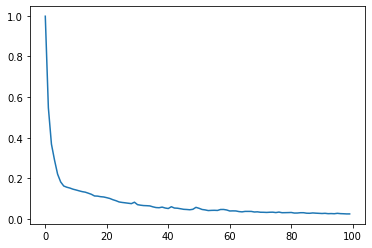

In [11]:
plt.plot(np.arange(len(epoch_losses)), [e_l.detach().cpu() for e_l in epoch_losses])

In [12]:
train_data.next_task()
train_loader = data.DataLoader(train_data, batch_size=36)
trainer.next_task(new_classes = [3,2])#,2,2,2])
test_data.next_task()
test_loader = data.DataLoader(test_data, batch_size=8)
optimizer = torch.optim.Adam(lr = 0.0005, params=trainer.model.parameters())
trainer.optim = optimizer
metrics_manager = MetricsManager(["confusion_matrix"], n_classes=5)
evaluater = Evaluater(trainer.model, metrics_manager)

for i in range(100):
  trainer.train(0, train_loader)
evaluater.test(test_loader)
torch.save(model.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

{'n_classes': 5}
[[5.18355e+06 0.00000e+00 0.00000e+00 1.38550e+04 1.13070e+04]
 [1.17963e+05 0.00000e+00 0.00000e+00 1.37500e+03 3.08000e+02]
 [5.76160e+04 0.00000e+00 0.00000e+00 5.15000e+02 1.87000e+02]
 [1.88260e+04 0.00000e+00 0.00000e+00 7.47750e+04 2.98500e+03]
 [1.51940e+04 0.00000e+00 0.00000e+00 1.88500e+03 7.96590e+04]]


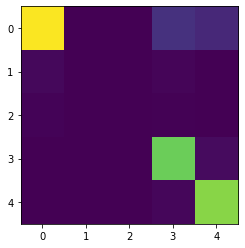

In [49]:
plt.imshow(metrics_manager.metrics[0].confusion_matrix/np.sum(metrics_manager.metrics[0].confusion_matrix, axis=-1), vmax=1)

In [50]:
train_data.next_task()
train_loader = data.DataLoader(train_data, batch_size=36)
trainer.next_task(new_classes = [3,2,2])#,2,2,2])
test_data.next_task()
test_loader = data.DataLoader(test_data, batch_size=8)
optimizer = torch.optim.Adam(lr = 0.0005, params=trainer.model.parameters())
trainer.optim = optimizer
metrics_manager = MetricsManager(["confusion_matrix"], n_classes=7)
evaluater = Evaluater(trainer.model, metrics_manager)

for i in range(100):
  trainer.train(0, train_loader)
evaluater.test(test_loader)
torch.save(model.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

{'n_classes': 7}
[[6.035098e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.192700e+04 6.785000e+03]
 [1.186840e+05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  3.180000e+02 6.440000e+02]
 [5.715800e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.081000e+03 7.900000e+01]
 [9.510100e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  7.300000e+02 7.550000e+02]
 [9.362900e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.860000e+02 2.923000e+03]
 [1.977700e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  6.920900e+04 1.340000e+02]
 [2.039400e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  5.700000e+01 5.693100e+04]]


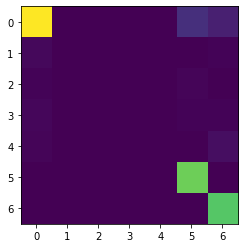

In [51]:
plt.imshow(metrics_manager.metrics[0].confusion_matrix/np.sum(metrics_manager.metrics[0].confusion_matrix, axis=-1))

In [52]:
train_data.next_task()
train_loader = data.DataLoader(train_data, batch_size=36)
trainer.next_task(new_classes = [3,2,2,2])#,2,2,2])
test_data.next_task()
test_loader = data.DataLoader(test_data, batch_size=8)
optimizer = torch.optim.Adam(lr = 0.0005, params=trainer.model.parameters())
trainer.optim = optimizer
metrics_manager = MetricsManager(["confusion_matrix"], n_classes=9)
evaluater = Evaluater(trainer.model, metrics_manager)

for i in range(100):
  trainer.train(0, train_loader)
evaluater.test(test_loader)
torch.save(model.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

{'n_classes': 9}
[[6.328108e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.076800e+04 1.165700e+04]
 [1.159500e+05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.359000e+03 2.337000e+03]
 [5.500400e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 8.990000e+02 2.415000e+03]
 [9.063300e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 7.460000e+02 5.207000e+03]
 [9.479300e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.420000e+02 1.803000e+03]
 [8.641300e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.310000e+03 1.397000e+03]
 [7.559500e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 7.450000e+02 1.042000e+03]
 [1.565700e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 7.204400e+04 6.740000e+02]
 [1.487

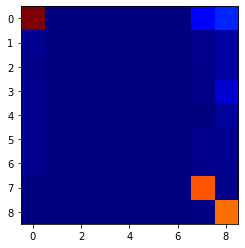

In [54]:
plt.imshow(metrics_manager.metrics[0].confusion_matrix/np.sum(metrics_manager.metrics[0].confusion_matrix, axis=-1), cmap="jet")

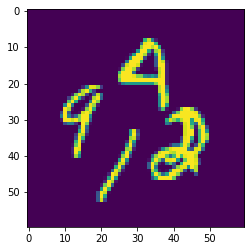

[0 3 4]


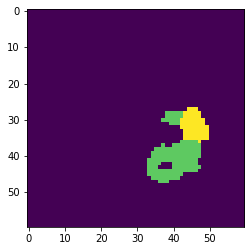

****


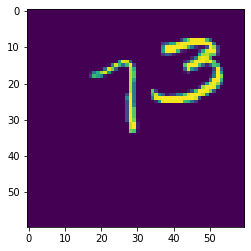

[0 4]


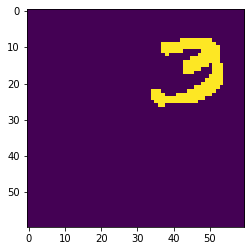

****


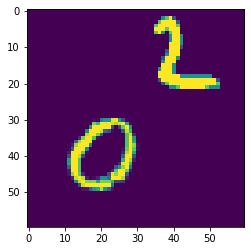

[0 3]


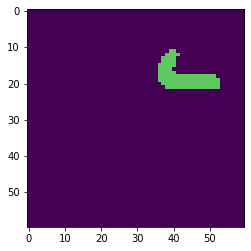

****


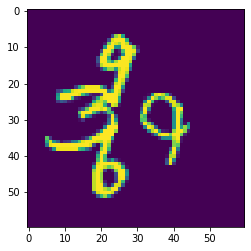

[0 4]


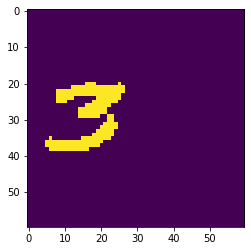

****


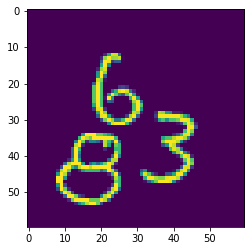

[0 4]


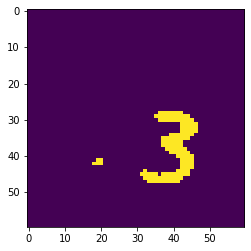

****


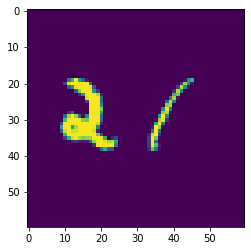

[0 3]


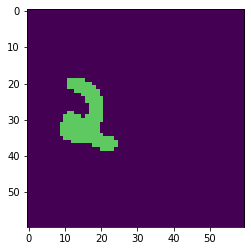

****


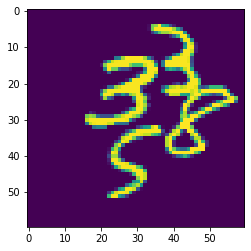

[0 4]


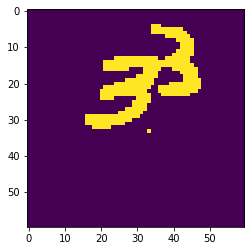

****


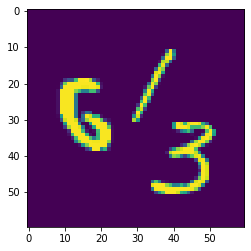

[0 4]


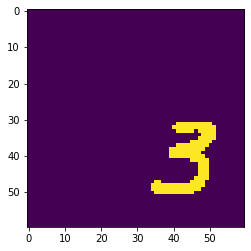

****


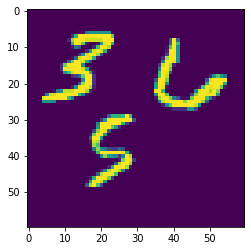

[0 4]


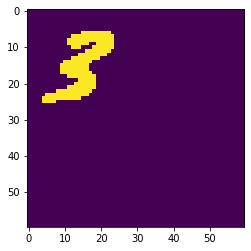

****


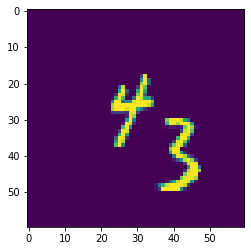

[0 4]


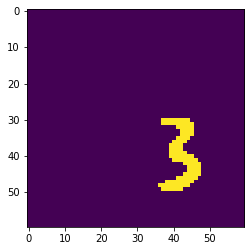

****


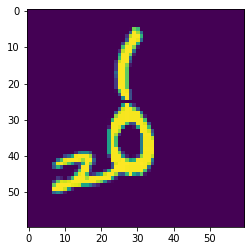

[0 3 4]


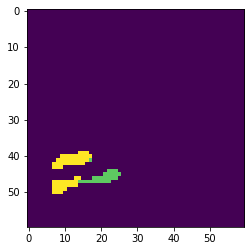

****


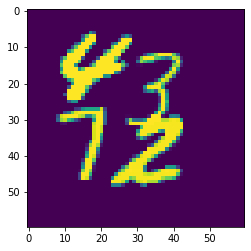

[0 3 4]


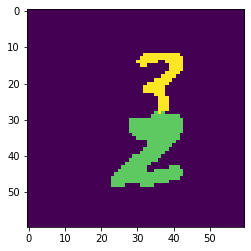

****


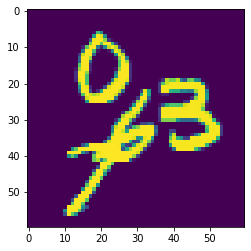

[0 3 4]


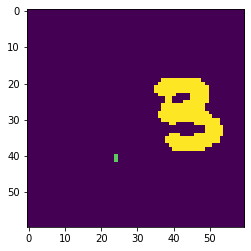

****


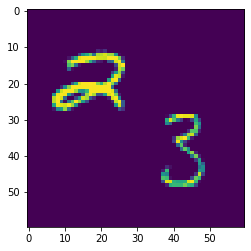

[0 3 4]


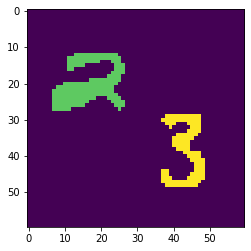

****


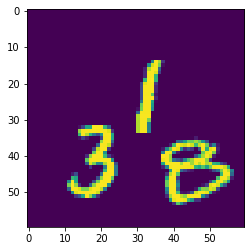

[0 4]


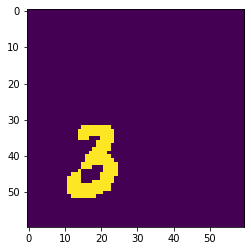

****


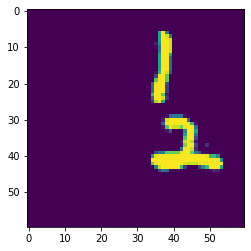

[0 3 4]


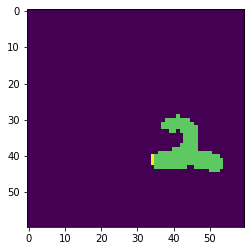

****


In [ ]:
trainer.model.eval()
for j, (images, labels) in enumerate(test_loader):
  x = trainer.model(images.cuda().float())
  plt.imshow(images[0][0])
  plt.show()
  _, pred = torch.max(x, dim=1)
  print(np.unique(pred[0].detach().cpu().numpy()))
  plt.imshow(pred[0].detach().cpu(), vmax=4)
  #plt.figure(figsize=(15, 5))
  #for i in range(5):
  #  plt.subplot(2, 5, i+1)
  #  plt.imshow(x[0,i].detach().cpu()>0.3)
  plt.show()
  print("****")
  if j == 15:
    break